In [20]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta

In [26]:
weather_data = pd.read_csv('C:/Users/Naisaile/Documents/PROYECTO-TESIS/Evapotranspiration-Prediction-2022/API/data/weather_station_data.csv')
weather_data = weather_data[['dt','dt_iso','temp','humidity','clouds_all']]


In [27]:
ts = weather_data.dt
for i in range(len(ts)):
    weather_data.dt[i] = (datetime.utcfromtimestamp(ts[i])-timedelta(hours=3)).strftime('%Y-%m-%d')

c:\Users\Naisaile\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-27-bff6da8b65d9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data.dt[i] = (datetime.utcfromtimestamp(ts[i])-timedelta(hours=3)).strftime('%Y-%m-%d')


In [29]:
weather_data = weather_data[3:]

In [79]:
tmax = weather_data[['dt','temp']].groupby(['dt']).max()
tmin = weather_data[['dt','temp']].groupby(['dt']).min()
tmean = weather_data[['dt','temp']].groupby(['dt']).mean()
rhmax = weather_data[['dt','humidity']].groupby(['dt']).max()
rhmin = weather_data[['dt','humidity']].groupby(['dt']).min()
rhmean = weather_data[['dt','humidity']].groupby(['dt']).mean()
clouds = weather_data[['dt','clouds_all']].groupby(['dt']).mean()

In [80]:
tmax.rename(columns = {'temp':'tmax'}, inplace = True)
tmin.rename(columns = {'temp':'tmin'}, inplace = True)
tmean.rename(columns = {'temp':'tmean'}, inplace = True)
rhmax.rename(columns = {'humidity':'rhmax'}, inplace = True)
rhmin.rename(columns = {'humidity':'rhmin'}, inplace = True)
rhmean.rename(columns = {'humidity':'rhmean'}, inplace = True)
clouds.rename(columns = {'clouds_all':'clouds'}, inplace = True)


In [82]:
df_wdata = pd.concat([tmax,tmin,tmean,rhmax,rhmin,rhmean,clouds],axis=1)

In [85]:
from pyet.combination import pm_fao56
from pyet.rad_utils import calc_rad_sol_in
from pyet.meteo_utils import daylight_hours
lat_rad = float(-33.3971255) * 0.01745329251
df_wdata.index = pd.to_datetime(df_wdata.index,format='%Y-%m-%d')

In [89]:
wind = []
for i in range(len(df_wdata)):
    wind.append(0.0)

In [90]:
df_wdata['wind'] = wind

In [92]:
df_wdata['rs'] = calc_rad_sol_in(tindex = df_wdata.index,
                        lat = lat_rad,
                        n = (1-(df_wdata.clouds/100))*daylight_hours(df_wdata.index,lat_rad)[0])
df_wdata['eto'] = pm_fao56(tmean = df_wdata.tmean,
                        tmin = df_wdata.tmin,
                        tmax = df_wdata.tmax,
                        rh = df_wdata.rhmean,
                        rhmin = df_wdata.rhmin,
                        rhmax = df_wdata.rhmax,
                        wind = df_wdata.wind,
                        rs = df_wdata.rs,
                        lat = lat_rad,
                        elevation = 20.0)

In [93]:
df_wdata

,tmax,tmin,tmean,rhmax,rhmin,rhmean,clouds,rs,wind,eto
dt,,,,,,,,,,
2016-01-01,29.71,15.76,22.675833,76,27,49.916667,11.291667,30.599919,0.0,5.044160
2016-01-02,29.65,14.43,22.109583,87,33,59.041667,25.000000,27.563833,0.0,4.665472
2016-01-03,25.50,15.14,21.323333,77,39,54.458333,41.458333,23.921222,0.0,4.072057
2016-01-04,26.59,18.66,22.232083,72,26,51.166667,78.291667,15.786964,0.0,2.919513
2016-01-05,29.34,18.58,23.088750,68,25,52.583333,74.583333,16.591611,0.0,3.060717
...,...,...,...,...,...,...,...,...,...,...
2022-10-25,21.66,12.59,16.446250,67,35,51.666667,15.208333,27.404974,0.0,3.797213
2022-10-26,23.56,11.82,17.473750,74,27,50.958333,15.000000,27.534879,0.0,3.863024
2022-10-27,26.14,14.14,19.864167,58,23,42.041667,0.000000,30.763738,0.0,4.457778


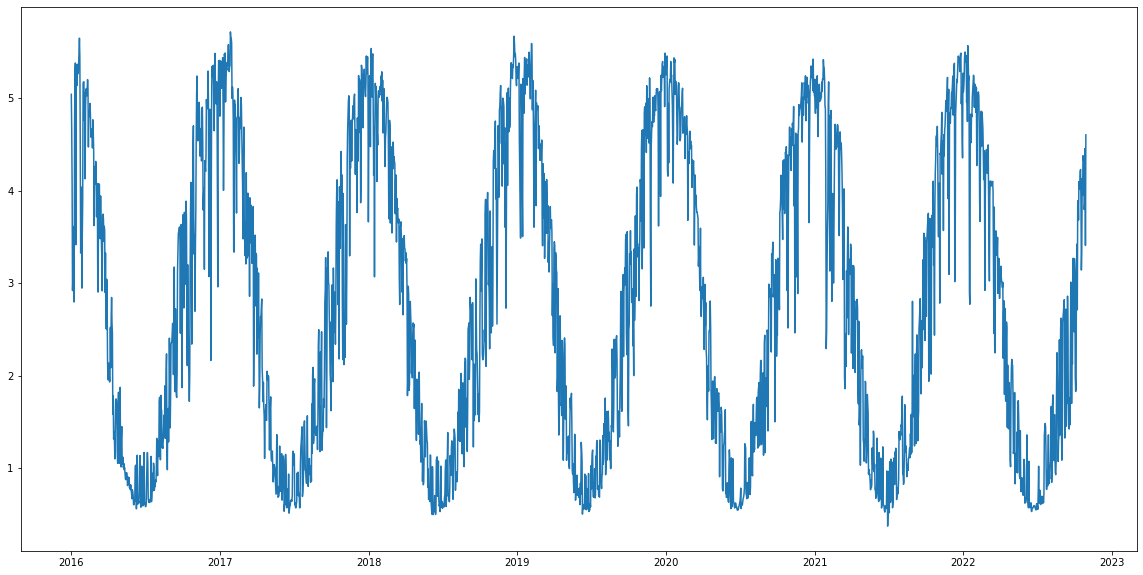

In [95]:
import matplotlib.pylab as plt
fig = plt.figure(figsize=(20,10))
plt.plot(df_wdata['eto'])

In [100]:
df_eto = pd.DataFrame({'Data': df_wdata.index,'Eto':df_wdata.eto.values})

In [102]:
df_eto = df_eto.set_index('Data')

In [104]:
df_eto.to_csv('C:/Users/Naisaile/Documents/PROYECTO-TESIS/Evapotranspiration-Prediction-2022/API/data/eto_data.csv')